In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from matplotlib import patches, cm
import matplotlib.colors as mcolors
import albumentations as A

from endoanalysis.keypoints import load_keypoints, KeypointsTruthArray
from endoanalysis.nucprop import NucleiPropagator


In [2]:
NUM_IMAGES=3
FIGSIZE = 12
POINTS_SIZE = 3
TARGET_SIZE=(256,256)
CMAP = {0:"cyan", 1: "chartreuse", 2: "red"}

images_dir = "../data/Dataset/images/Bulk/Pathologists/"
images_context_dir = "../data/Dataset/images_context//Bulk/Pathologists/"
labels_dir = "../data/Dataset/labels/Bulk/Pathologists/"
propagator = NucleiPropagator(window_size = 100, min_area=12, max_area=789,average_area=16)

In [3]:
all_ids = [x for x in  os.listdir(images_dir)]

In [4]:
ids_chosen = ['1313.png', '223.png', '1541.png']

In [5]:
# ids_chosen =np.random.choice(all_ids, size=NUM_IMAGES)
images_paths = [os.path.join(images_dir, x) for x in ids_chosen]
images_context_paths = [os.path.join(images_context_dir, x) for x in ids_chosen]
labels_paths = [os.path.join(labels_dir, x.split(".")[0] + ".txt") for x in ids_chosen]

# images_batch = [cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB)  for x in images_paths]

# keypoints_batch = [ load_keypoints(x) for x in labels_paths]

In [6]:
images_context_batch = [cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB) for x in images_context_paths]


In [7]:
for image_context in images_context_batch:
    x_size, y_size = image_context.shape[:2]
    image_context = cv2.rectangle(
        image_context, 
        (np.round( y_size / 3).astype(int),
         np.round( x_size / 3).astype(int)), 
        (np.round( 2 * y_size / 3).astype(int),
         np.round( 2 * x_size / 3).astype(int)), 
        (0,200,0),
        8
    )

In [8]:
keypoints_batch = []
images_batch = []
for image_path, keypoints_path in zip(images_paths, labels_paths):
    transorm = A.Compose(
        [
            A.Resize(height=TARGET_SIZE[0], 
                     width=TARGET_SIZE[1])
        ], 
        keypoint_params=A.KeypointParams(format="xy")
    )
    
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)  
    keypoints = load_keypoints(keypoints_path)

    if keypoints:
        keypoints = np.array(keypoints)
        coords = keypoints[:,0:2]
        class_labels = keypoints[:,2]
    else: 
        coords = []

    transformed = transorm(image = image, keypoints=coords)


    #     class_labels = [x[-1] for x in keypoints]
    #     keypoints_no_class = [x[:-1] for x in keypoints]

    keypoints = [
        np.array(y + (x,)) for x, y in zip(class_labels, transformed["keypoints"])
    ]
              
    if keypoints:
        keypoints = np.stack(keypoints)
    else:
        keypoints = np.empty((0,3))

    keypoints = KeypointsTruthArray(keypoints.astype(float))
    keypoints_batch.append(keypoints)
    images_batch.append(image)


In [9]:
class_labels = [0.,1.,2.]

In [10]:
for label in class_labels:
    keypoints_label = keypoints[keypoints.classes == label]
    masks, borders = propagator.generate_masks(image, keypoints)
    masks = propagator.masks_to_image_size(image, masks, borders)
    color = mcolors.to_rgb(CMAP[class_labels[0]]) 
    color = tuple(int(x*255) for x in color)
    contoured_masks = propagator.generate_contoured_masks(masks, alpha=0.7, color = color, dilate = True)
    

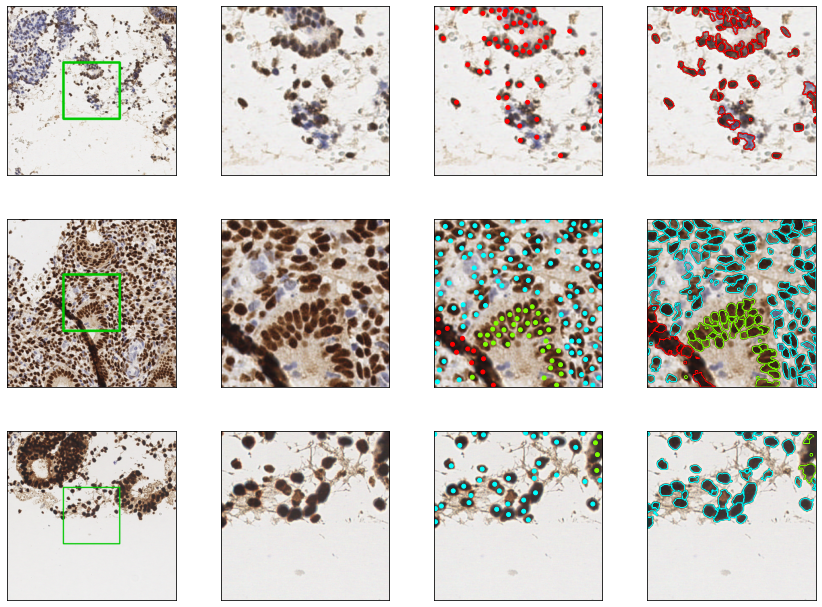

In [11]:

fig, ax = plt.subplots( NUM_IMAGES, 4, figsize= (FIGSIZE,FIGSIZE* NUM_IMAGES/4))
fig.tight_layout()
for image_i, (image, image_context, keypoints )in enumerate(zip(images_batch, images_context_batch, keypoints_batch)):
    ax[image_i, 0].imshow(image_context)
    ax[image_i, 1].imshow(image)
    ax[image_i, 2].imshow(image)
    x_coords = keypoints.x_coords()
    y_coords = keypoints.y_coords()
    for x, y, label in zip(keypoints.x_coords(), keypoints.y_coords(), keypoints.classes()):
        color = CMAP[label]
        patch = patches.Circle((x, y), color=color, radius=POINTS_SIZE)
        ax[image_i, 2].add_patch(patch)
        

    ax[image_i, 3].imshow(image)     
    for label in class_labels:
        keypoints_label = keypoints[keypoints.classes() == label]
        
        masks, borders = propagator.generate_masks(image, keypoints_label)
        masks = propagator.masks_to_image_size(image, masks, borders)
        color = mcolors.to_rgb(CMAP[label]) 
        color = tuple(int(x*255) for x in color)
        contoured_masks = propagator.generate_contoured_masks(masks, alpha=1., color = color, dilate = True)
        
        for mask in contoured_masks:
            ax[image_i, 3].imshow(mask)

        
    for i in range(4): 
        ax[image_i,i].tick_params(
            axis='both',          
            which='both',       
            bottom=False,      
            left=False,
            labelbottom=False,
            labelleft=False
        ) 


fig.savefig("figs/images_context.png")